In [77]:
from dotenv import load_dotenv

load_dotenv()

True

In [78]:
%pip install -U ddgs

Note: you may need to restart the kernel to use updated packages.


In [79]:
%pip install -qU "langchain-google-community[gmail]"

Note: you may need to restart the kernel to use updated packages.


In [80]:
%pip install --upgrade --quiet langchain-community arxiv

Note: you may need to restart the kernel to use updated packages.


In [81]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [82]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

In [83]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [84]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
  build_resource_service,
  get_gmail_credentials
)

SCOPES = [
    "https://www.googleapis.com/auth/gmail.readonly",
    "https://www.googleapis.com/auth/gmail.compose",
    "https://www.googleapis.com/auth/gmail.send",
]

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=SCOPES,
    client_sercret_file="./google/gmail_credentials.json",
)

api_resource = build_resource_service(credentials=credentials)
gmail_toolKit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolKit.get_tools()

C:\Users\jo\AppData\Local\Temp\ipykernel_36088\523952650.py:13: DeprecationWarning: get_gmail_credentials is deprecated and will be removed in a future version.Use get_google_credentials instead.
  credentials = get_gmail_credentials(
C:\Users\jo\AppData\Local\Temp\ipykernel_36088\523952650.py:19: DeprecationWarning: build_resource_service is deprecated and will be removed in a future version.Use build_gmail_service instead.
  api_resource = build_resource_service(credentials=credentials)


In [85]:
from langchain_community.agent_toolkits.load_tools import load_tools

loaded_tool_list = load_tools(
  ["arxiv"]
)

In [86]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = Chroma(
  embedding_function=embedding_function,
  collection_name="real_estate_tax",
  persist_directory="./chroma_db"  # ✅ 디렉터리
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
  retriever=retriever,
  name='real_estate_tax_retriever',
  description='Useful for answering questions about real estate tax in South Korea.'
)

In [87]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [88]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [89]:
def agent(state: MessagesState) :
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages' : [response]}

In [90]:
from langgraph.graph import END

def should_continue(state : MessagesState):
    message = state['messages']
    last_ai_message = message[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    return END

In [91]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [92]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition
graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
  'agent',
   tools_condition,
)
graph_builder.add_edge('tools', 'agent')

In [93]:
graph = graph_builder.compile()

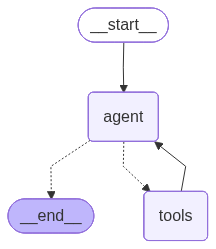

In [94]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [95]:
from langchain_core.messages import HumanMessage
query = '집이 15억일 때 종합부동산세를 계산해줄 수 있나요?'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values') :
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 15억일 때 종합부동산세를 계산해줄 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_R1xYt5lyXCyS16yTrbCDtNw8)
 Call ID: call_R1xYt5lyXCyS16yTrbCDtNw8
  Args:
    query: 15억 종합부동산세 계산
================================= Tool Message =================================
Name: real_estate_tax_retriever

종합부동산세법

[시행 2023. 4. 18] [법률 제19342호, 2023. 4. 18, 일부개정]
기획재정부 (재산세제과) 044-215-4313

제1장 총칙

제1조(목적) 이 법은 고액의 부동산 보유자에 대하여 종합부동산세를 부과하여 부동산보유에 대한 조세부담의 형평성을 제고하고, 부동산의 가격안정을 도모함으로써 지방재정의 균형발전과 국민경제의 건전한 발전에 이바지함을 목적으로 한다.

제2조(정의) 이 법에서 사용하는 용어의 정의는 다음 각호와 같다. <개정 2005. 12. 31., 2010. 3. 31., 2016. 1. 19., 2018. 12. 31., 2020. 6. 9., 2023. 3. 14.>
1. "시·군·구"란 함은 「지방자치법」 제2조에 따른 지방자치단체인 시·군 및 자치구(이하 "시·군·구"이라 한다)를 말한다.
2. "시장·군수·구청장"이라 함은 지방자치단체의 장인 시장·군수 및 자치구의 구청장(이하 "시장·군수·구청장"이라 한다)를 말한다.
3. "주택"이라 함은 「지방세법」 제104조제3호에 의한 주택을 말한다.
4. "토지"라